# Face Recognition Notebook

This notebook demonstrates face recognition using Python. We'll cover:
- Face detection in images
- Face encoding and recognition
- Building a simple face recognition system

## Prerequisites

Make sure you have the required libraries installed:
```bash
pip install face_recognition opencv-python pillow numpy
```

## 1. Import Required Libraries

In [45]:
import face_recognition
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from pathlib import Path

print("Libraries imported successfully!")
print(f"face_recognition version: {face_recognition.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Libraries imported successfully!
face_recognition version: 1.2.3
OpenCV version: 4.12.0


## 2. Helper Functions

In [46]:
def display_image(image, title="Image", figsize=(10, 8)):
    """
    Display an image using matplotlib
    """
    plt.figure(figsize=figsize)
    if len(image.shape) == 3:
        # Convert BGR to RGB for matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_face_boxes(image, face_locations, labels=None):
    """
    Draw boxes around detected faces - IMPROVED VERSION
    Label is placed ABOVE the face box so it doesn't cover the face
    """
    image_copy = image.copy()
    
    for i, (top, right, bottom, left) in enumerate(face_locations):
        # Draw thin rectangle around face
        cv2.rectangle(image_copy, (left, top), (right, bottom), (0, 255, 0), 2)
        
        # Add label ABOVE the box if provided
        if labels and i < len(labels):
            label = labels[i]
            
            # Calculate label size
            font = cv2.FONT_HERSHEY_DUPLEX
            font_scale = 0.8
            thickness = 1
            (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
            
            # Position label ABOVE the face box
            label_top = top - text_height - 10
            label_bottom = top - 5
            
            # If label would go off top of image, put it below instead
            if label_top < 0:
                label_top = bottom + 5
                label_bottom = bottom + text_height + 10
            
            # Draw semi-transparent background for label
            cv2.rectangle(image_copy, 
                         (left, label_top), 
                         (left + text_width + 10, label_bottom), 
                         (0, 255, 0), 
                         cv2.FILLED)
            
            # Draw text
            cv2.putText(image_copy, label, 
                       (left + 5, label_bottom - 8), 
                       font, font_scale, (255, 255, 255), thickness)
    
    return image_copy

print("Helper functions defined!")

Helper functions defined!


## 3. Face Detection

Let's start with basic face detection. We'll detect faces in an image.

In [47]:
# Create a sample directory structure
Path("images").mkdir(exist_ok=True)
Path("known_faces").mkdir(exist_ok=True)

print("Created directories: 'images' and 'known_faces'")
print("\nPlease add your images to these directories:")
print("- 'images/': Images to test face detection/recognition")
print("- 'known_faces/': Images of known people (name the files as 'PersonName.jpg')")

Created directories: 'images' and 'known_faces'

Please add your images to these directories:
- 'images/': Images to test face detection/recognition
- 'known_faces/': Images of known people (name the files as 'PersonName.jpg')


In [48]:
def detect_faces_in_image(image_path):
    """
    Detect all faces in an image
    """
    # Load image
    image = face_recognition.load_image_file(image_path)
    
    # Find all face locations
    face_locations = face_recognition.face_locations(image)
    
    print(f"Found {len(face_locations)} face(s) in the image.")
    
    # Draw boxes around faces
    image_with_boxes = draw_face_boxes(image, face_locations)
    
    return image_with_boxes, face_locations

# Example usage (uncomment when you have an image):
# image_with_faces, locations = detect_faces_in_image("images/your_image.jpg")
# display_image(image_with_faces, "Detected Faces")

## 4. Face Encoding and Recognition

Now let's create a face recognition system that can identify known faces.

In [49]:
class FaceRecognitionSystem:
    """
    A simple face recognition system
    """
    def __init__(self):
        self.known_face_encodings = []
        self.known_face_names = []
    
    def load_known_faces(self, folder_path="known_faces"):
        """
        Load and encode all faces from a folder
        Expected filename format: PersonName.jpg
        """
        folder = Path(folder_path)
        
        if not folder.exists():
            print(f"Folder '{folder_path}' not found!")
            return
        
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))
        
        print(f"Loading {len(image_files)} known face(s)...")
        
        for image_path in image_files:
            # Load image
            image = face_recognition.load_image_file(str(image_path))
            
            # Get face encoding
            encodings = face_recognition.face_encodings(image)
            
            if encodings:
                # Use the first face found
                encoding = encodings[0]
                name = image_path.stem  # Filename without extension
                
                self.known_face_encodings.append(encoding)
                self.known_face_names.append(name)
                
                print(f"  ✓ Loaded: {name}")
            else:
                print(f"  ✗ No face found in: {image_path.name}")
        
        print(f"\nTotal known faces loaded: {len(self.known_face_names)}")
    
    def recognize_faces(self, image_path, tolerance=0.6):
        """
        Recognize faces in an image
        
        Args:
            image_path: Path to the image file
            tolerance: How strict the face comparison should be (lower is stricter)
        """
        # Load image
        image = face_recognition.load_image_file(image_path)
        
        # Find all faces
        face_locations = face_recognition.face_locations(image)
        face_encodings = face_recognition.face_encodings(image, face_locations)
        
        print(f"Found {len(face_locations)} face(s) in the image.\n")
        
        labels = []
        
        # Compare each face
        for face_encoding, face_location in zip(face_encodings, face_locations):
            # Compare with known faces
            matches = face_recognition.compare_faces(
                self.known_face_encodings, face_encoding, tolerance=tolerance
            )
            
            name = "Unknown"
            
            # Calculate face distances
            face_distances = face_recognition.face_distance(
                self.known_face_encodings, face_encoding
            )
            
            if len(face_distances) > 0:
                best_match_index = np.argmin(face_distances)
                
                if matches[best_match_index]:
                    name = self.known_face_names[best_match_index]
                    confidence = 1 - face_distances[best_match_index]
                    print(f"Recognized: {name} (Confidence: {confidence:.2%})")
                else:
                    print(f"Unknown face detected")
            
            labels.append(name)
        
        # Draw boxes and labels
        result_image = draw_face_boxes(image, face_locations, labels)
        
        return result_image, labels

print("FaceRecognitionSystem class defined!")

FaceRecognitionSystem class defined!


## 5. Initialize and Use the Face Recognition System

In [50]:
# Create the face recognition system
fr_system = FaceRecognitionSystem()

# Load known faces
fr_system.load_known_faces("known_faces")

Loading 4 known face(s)...
  ✓ Loaded: leah1
  ✓ Loaded: anna1
  ✓ Loaded: ann2
  ✓ Loaded: zend1

Total known faces loaded: 4


PROCESSING YOUR ACTUAL IMAGES
Processing 11 image(s)...


Processing: zend2.jpeg
Found 1 face(s) in the image.

Recognized: zend1 (Confidence: 53.38%)


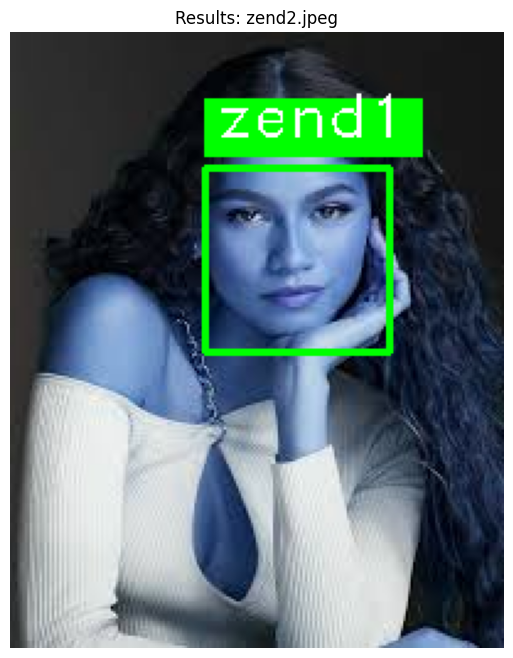


Processing: anna6.jpeg
Found 1 face(s) in the image.

Recognized: anna1 (Confidence: 63.57%)


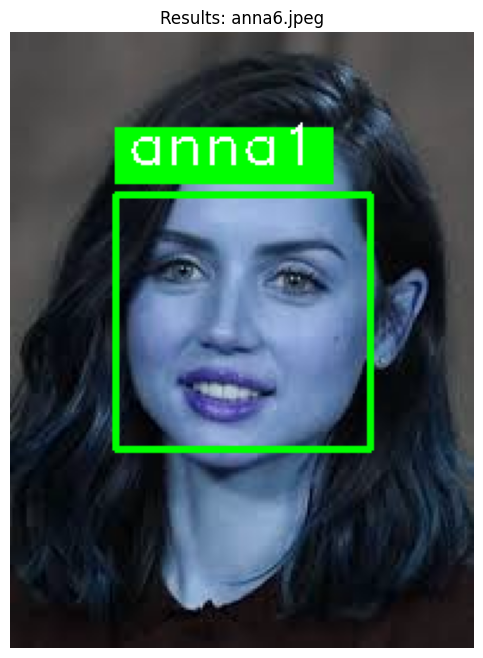


Processing: zend5.jpeg
Found 1 face(s) in the image.

Recognized: zend1 (Confidence: 67.33%)


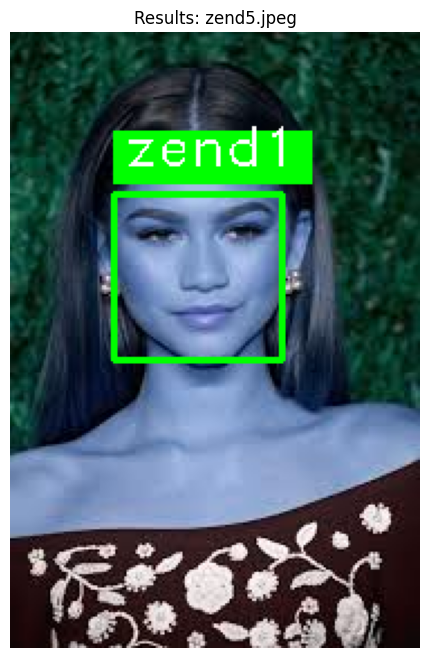


Processing: zend4.jpeg
Found 1 face(s) in the image.

Recognized: zend1 (Confidence: 55.74%)


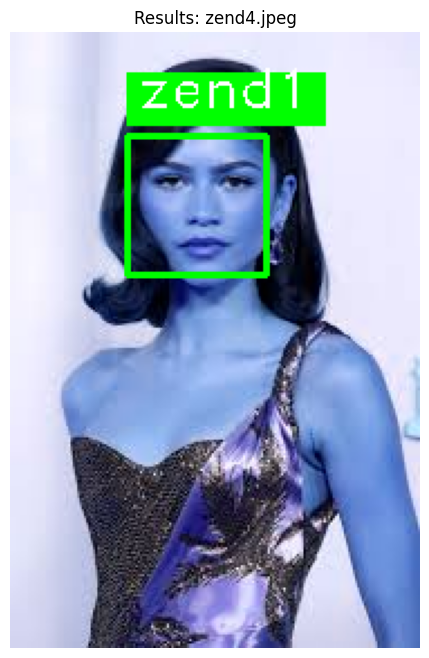


Processing: anna4.jpeg
Found 1 face(s) in the image.

Recognized: anna1 (Confidence: 57.19%)


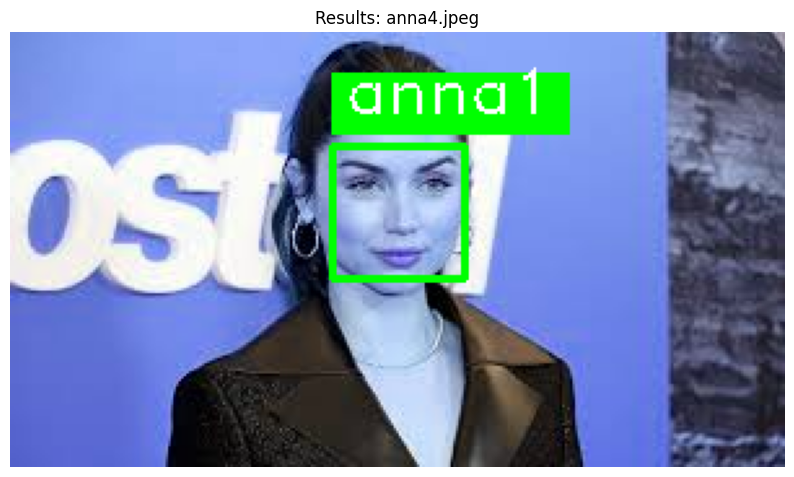


Processing: leah5.jpeg
Found 1 face(s) in the image.

Recognized: leah1 (Confidence: 57.09%)


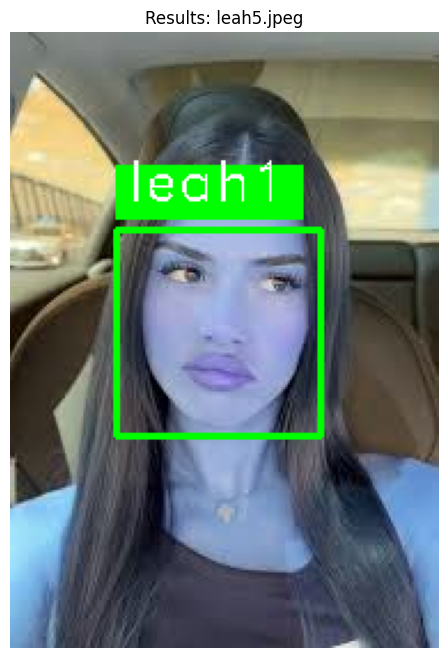


Processing: leah4.jpeg
Found 1 face(s) in the image.

Recognized: leah1 (Confidence: 46.90%)


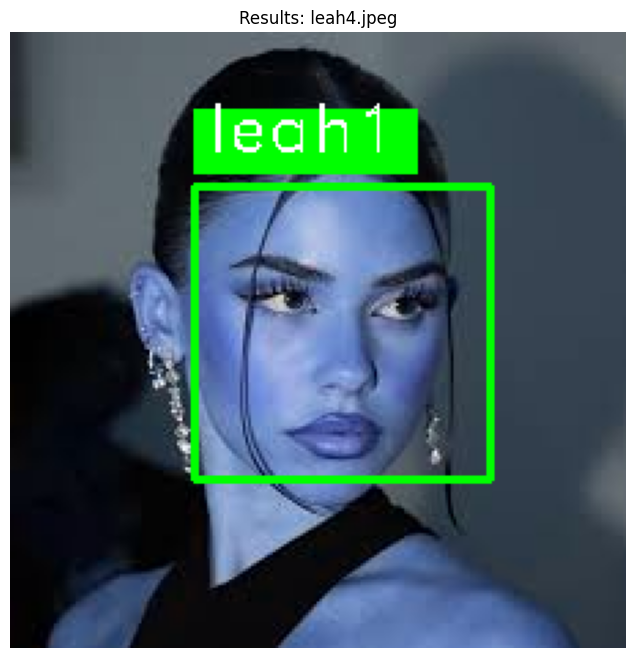


Processing: anna5.jpeg
Found 1 face(s) in the image.

Recognized: anna1 (Confidence: 61.43%)


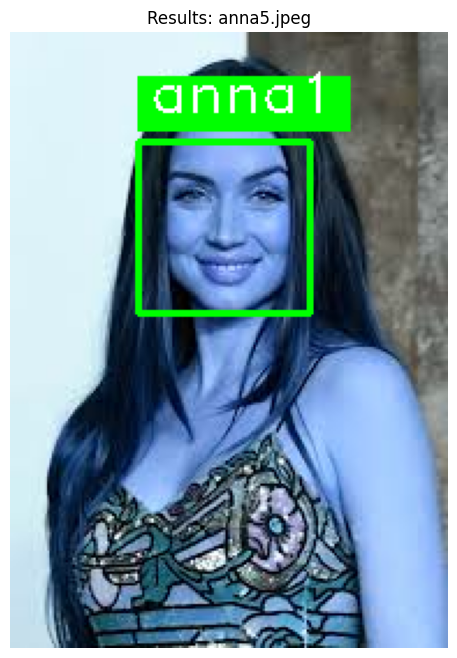


Processing: leah3.jpeg
Found 1 face(s) in the image.

Recognized: leah1 (Confidence: 42.30%)


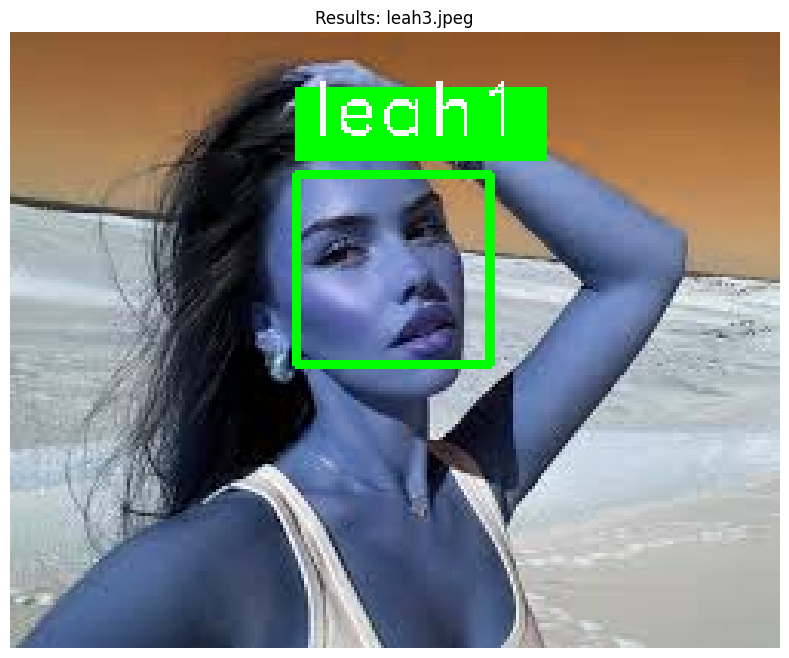


Processing: leah2.jpeg
Found 1 face(s) in the image.

Recognized: leah1 (Confidence: 51.04%)


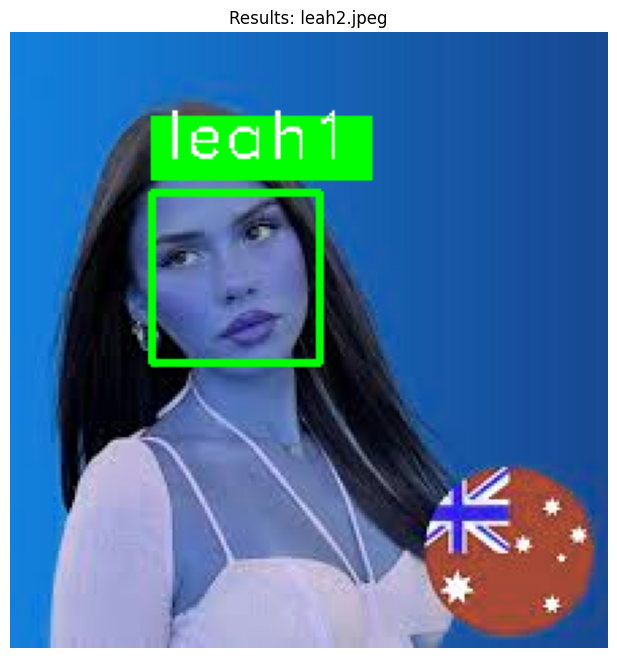


Processing: anna3.jpeg
Found 1 face(s) in the image.

Recognized: anna1 (Confidence: 72.59%)


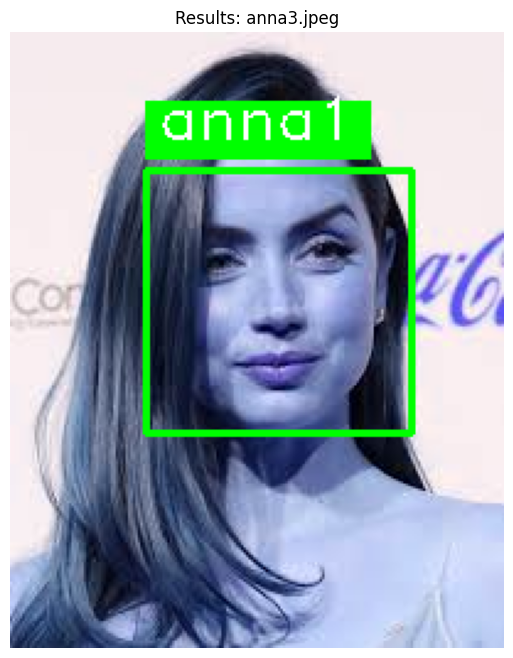

In [51]:
# ACTUAL TEST: Process all your images
print("=" * 60)
print("PROCESSING YOUR ACTUAL IMAGES")
print("=" * 60)

# Test on all images in the images folder
batch_process_images(fr_system, "images")

## 6. Webcam Face Recognition (Real-time)

This section provides code for real-time face recognition using your webcam.

## IMPORTANT: Your Current Setup

**Current Training Data (known_faces/):**
- 6 images of Anna

**Current Test Data (images/):**
- Images of Leah
- Images of Zend

**Problem:** The system can only recognize people it has been trained on! 

Since you only trained on Anna, it will mark Leah and Zend as "Unknown".

**Solution:** Move training images for each person:

```bash
# For proper training, organize like this:
known_faces/
├── anna1.jpeg, anna2.jpeg, anna3.jpeg  (keep 2-3 for training)
├── leah1.jpeg, leah2.jpeg  (move from images/)
└── zend1.jpeg, zend2.jpeg  (move from images/)

images/
├── anna4.jpeg, anna5.jpeg  (keep for testing)
├── leah3.jpeg, leah4.jpeg  (keep for testing)
└── zend3.jpeg, zend4.jpeg  (keep for testing)
```

Then re-run the training cells!

In [52]:
def webcam_face_recognition(fr_system, process_every_n_frames=2):
    """
    Real-time face recognition using webcam
    
    Args:
        fr_system: FaceRecognitionSystem instance
        process_every_n_frames: Process every nth frame (for performance)
    
    Press 'q' to quit
    """
    video_capture = cv2.VideoCapture(0)
    
    if not video_capture.isOpened():
        print("Error: Could not open webcam")
        return
    
    frame_count = 0
    face_locations = []
    face_names = []
    
    print("Starting webcam... Press 'q' to quit")
    
    while True:
        ret, frame = video_capture.read()
        
        if not ret:
            print("Error: Failed to capture frame")
            break
        
        # Process only every nth frame for performance
        if frame_count % process_every_n_frames == 0:
            # Resize frame for faster processing
            small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
            rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
            
            # Find faces
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
            
            face_names = []
            for face_encoding in face_encodings:
                matches = face_recognition.compare_faces(
                    fr_system.known_face_encodings, face_encoding, tolerance=0.6
                )
                name = "Unknown"
                
                if True in matches and len(fr_system.known_face_encodings) > 0:
                    face_distances = face_recognition.face_distance(
                        fr_system.known_face_encodings, face_encoding
                    )
                    best_match_index = np.argmin(face_distances)
                    if matches[best_match_index]:
                        name = fr_system.known_face_names[best_match_index]
                
                face_names.append(name)
        
        # Display results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4
            
            # Draw box and label
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 255, 0), cv2.FILLED)
            cv2.putText(frame, name, (left + 6, bottom - 6), 
                       cv2.FONT_HERSHEY_DUPLEX, 0.6, (255, 255, 255), 1)
        
        # Display frame
        cv2.imshow('Face Recognition', frame)
        
        frame_count += 1
        
        # Exit on 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    video_capture.release()
    cv2.destroyAllWindows()
    print("Webcam stopped")

# To run webcam recognition (uncomment):
# webcam_face_recognition(fr_system)

## 7. Batch Processing

Process multiple images at once

In [53]:
def batch_process_images(fr_system, folder_path="images"):
    """
    Process all images in a folder
    """
    folder = Path(folder_path)
    
    if not folder.exists():
        print(f"Folder '{folder_path}' not found!")
        return
    
    image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))
    
    if not image_files:
        print(f"No images found in '{folder_path}'")
        return
    
    print(f"Processing {len(image_files)} image(s)...\n")
    
    for image_path in image_files:
        print(f"\nProcessing: {image_path.name}")
        print("=" * 50)
        
        try:
            result_image, recognized_names = fr_system.recognize_faces(str(image_path))
            display_image(result_image, f"Results: {image_path.name}")
        except Exception as e:
            print(f"Error processing {image_path.name}: {e}")

# Example usage (uncomment when you have images):
# batch_process_images(fr_system, "images")

## 8. Save Face Encodings

Save and load face encodings for faster startup

In [54]:
import pickle

def save_encodings(fr_system, filename="face_encodings.pkl"):
    """
    Save face encodings to a file
    """
    data = {
        'encodings': fr_system.known_face_encodings,
        'names': fr_system.known_face_names
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    
    print(f"Encodings saved to {filename}")

def load_encodings(fr_system, filename="face_encodings.pkl"):
    """
    Load face encodings from a file
    """
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        fr_system.known_face_encodings = data['encodings']
        fr_system.known_face_names = data['names']
        
        print(f"Loaded {len(fr_system.known_face_names)} face encoding(s) from {filename}")
        return True
    except FileNotFoundError:
        print(f"File {filename} not found")
        return False

# Example usage:
# save_encodings(fr_system)
# load_encodings(fr_system)

## 9. Usage Instructions

### Quick Start Guide:

1. **Prepare Known Faces:**
   - Add photos of known people to the `known_faces/` folder
   - Name files as `PersonName.jpg` (e.g., `John_Doe.jpg`, `Jane_Smith.jpg`)
   - Use clear, frontal face photos for best results

2. **Prepare Test Images:**
   - Add images you want to test to the `images/` folder

3. **Run Recognition:**
   ```python
   # Initialize system
   fr_system = FaceRecognitionSystem()
   fr_system.load_known_faces("known_faces")
   
   # Recognize faces in an image
   result, names = fr_system.recognize_faces("images/test.jpg")
   display_image(result, "Recognition Results")
   
   # Or batch process
   batch_process_images(fr_system, "images")
   
   # Or use webcam
   webcam_face_recognition(fr_system)
   ```

### Tips for Better Results:
- Use high-quality, well-lit photos
- Ensure faces are clearly visible and frontal
- Avoid sunglasses or obstructions
- Adjust `tolerance` parameter (0.4-0.6) for stricter/looser matching

## 10. Advanced: Face Landmarks Detection

In [55]:
def detect_face_landmarks(image_path):
    """
    Detect facial landmarks (eyes, nose, mouth, etc.)
    """
    image = face_recognition.load_image_file(image_path)
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    print(f"Found {len(face_landmarks_list)} face(s) with landmarks")
    
    # Draw landmarks
    pil_image = Image.fromarray(image)
    
    for face_landmarks in face_landmarks_list:
        for facial_feature in face_landmarks.keys():
            points = face_landmarks[facial_feature]
            for point in points:
                cv2.circle(image, point, 2, (0, 255, 0), -1)
    
    return image, face_landmarks_list

# Example usage:
# landmarks_image, landmarks = detect_face_landmarks("images/test.jpg")
# display_image(landmarks_image, "Face Landmarks")
# print("\nDetected features:", landmarks[0].keys() if landmarks else "None")